# Lesson 2: Gradient Descent and Optimization

Video: How do computers 'learn'?

In [ ]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

## Gradient Descent

Lets consider the following situation. Say we have:
- A function (could be a neural net, could be the equation for a straight line...) that takes some input(s) and produces some output(s) based on a set of parameters - let's call them `w`.
- Some measure of how well this function performs. Maybe this is how poorly the function describes some pattern in your data, or how well a network does in a classification task. Let's call this measure the `loss`, where the goal is to make this as small as possible.

The question is often 'how do we find a set of parameters that gives the best possible result?'. There are a few ways we could try to solve this. The most basic might be:
- Try all possible values for all parameters
- Randomly guess and keep the best

Clearly both of these have some major flaws, and when we're dealing with thousands or millions of parameters there is no way you could try all possible combinations. So, we need a smarter approach.

### The Gradient Descent Algorithm

What if we could start from some set of parameters, and then see how to modify them slightly such that we get an improvement? Ideally, for each parameter we'd like to know what happens to the loss when we tweak that parameter slightly up or down. Formally, we'd like to know the **gradient of the loss with respect to that parameter**. You can think of the gradient as telling us which direction to move to get the biggest increase (or decrease if we go in the opposite direction).

IF we can find these gradients, then a sensible method for finding a good set of parameters to solve a given problem would be
1. Start with some random parameters
2. Find the gradient of the loss with respect to each parameter
3. Update each parameter such that you move some small amount in the direction of steepest descent
4. Go back to step 2, finding the gradients based on the new parameter values and repeat all this a bunch of times.

This is the gradient descent algorithm in a nutshell :) Let's do an example, where we'll create some data that roughtly follows a trend and try to approximate that trend with a straight line, which will be specified by two parameters. 

### Creating an Example Problem

<matplotlib.collections.PathCollection>

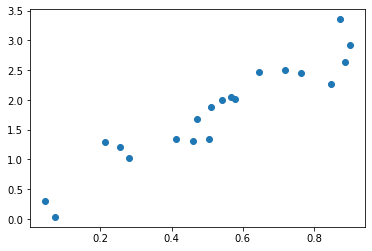

In [ ]:
# Creating some data:
x = torch.rand(20)
y = 3*x + 0.2 + torch.randn(20)*0.3 # y = ax + b + noise
plt.scatter(x, y) # It's always helpful to visualize what's going on wherever possible.

### 2.3 Defining our loss

We can describe a line as a function `y = ax + b` where a and b are our parameters. Take a look at the two lines shown here:

<matplotlib.legend.Legend>

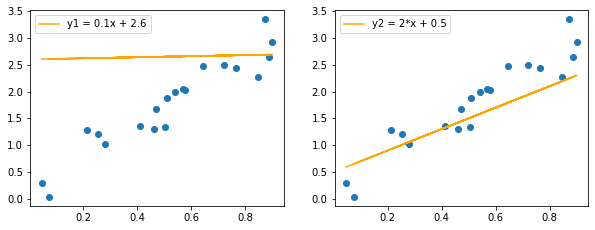

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.6))
axs[0].scatter(x, y)
axs[0].plot(x, 0.1*x + 2.6, label='y1 = 0.1x + 2.6', c='orange')
axs[0].legend()
axs[1].scatter(x, y)
axs[1].plot(x, 2*x + 0.5, label='y2 = 2*x + 0.5',  c='orange')
axs[1].legend()

Clearly one does a better job than the other at describing the trend in this data. But how do we quantify this? There are several measures used in this sort of case, with a popular one being the 'Root Mean Squared Error'. It sounds intimidating, but all we do is take the errors (how far each point is from the line), square them, sum the squares and then take the square root of that. More points further from the line -> higher errors (squaring takes care of any minus signs that would otherwise cause issues with points above/below the line) -> a higher final value for the RMSE. So lower is better. This is our loss function. 

Here's one way to implement this in code (there are also built-in functions for this and many other ways you could write it):

In [ ]:
def rmse(y, y_pred):
  return torch.mean((y-y_pred)**2)**0.5 # See how many ways you can write this

Using this loss function, we can quantify how well those lines match the data:

In [ ]:
y1 = 0.1*x + 2.6
y2 = 2*x + 0.5
print('RMSE for y_hat1 = 0.1x + 2.6:', rmse(y, y1))
print('RMSE for y_hat2 = 2*x + 0.5:', rmse(y, y2))

RMSE for y_hat1 = 0.1x + 2.6: tensor(1.1623)
RMSE for y_hat2 = 2*x + 0.5: tensor(0.4500)


The second line has a lower loss, and is therefore a better fit. Tweak the parameters and see if you can do even better.

**THINK/DISCUSS**: What is your thought process as you try this? Are you doing something like the gradient descent described earlier?

###2.4 Calculating Gradients

So, how do we find the gradients we keep talking about? If you're good at differentiation, you can look at a function and figure them out analytically. But this quickly breaks down when the function is complex or involves many steps. Fortunately, PyTorch does something called automatic differentiation, where it can keep track of every operation that happens to a tensor. It builds something called a computational graph, and when you want to calculate the gradients with respect to some final result you can simply call .backward() and PyTorch will trace the path back through this graph filling in the gradients at each step. We won't go too deep into this, but here's a simple example:

In [ ]:
# Some operations to demonstrate autograd
a = torch.tensor(5.7)
a.requires_grad = True # This is important - by default PyTorch won't track gradients

b = 5*a + 2

c = torch.sin(2*b+0.1)

c

tensor(-0.9871, grad_fn=<SinBackward0>)

Notice that `grad_fn` bit there? Because c depends on something (b) that depends on a tensor that requires_grad (a), PyTorch keeps track of the function needed to calculate the gradients. We could then see the gradient of c with respect to a with:

In [ ]:
c.backward() # Tell pytorch to propagate the gradients backwards down the chain of operations
a.grad # See the resulting gradient

tensor(-1.6036)

The derivative of c with respect to a is (10\*cos(10\*(a+0.41)) - plugging in a=5.7 we see that this does indeed give the answer dc/da = -1.603. This is quite magical - we can chain complex functions together and as long as eveything is differentiable we can rely on PyTorch to be able to work backwards and give us all the gradients we need.

### Gradient Descent on our Toy Example

Let's get back to that example we were playing with, trying to find the parameters for a line that best describes the trend in our data. 

We create our parameters `w` (initialized to 2 random floats) and tell pytorch to keep track of gradients. 

Then, in a loop, we repeatedly find the loss, find the gradients (`loss.backward()`) and update the parameters accordingly. We could do this ourselves but PyTorch provides an optimizer that handles the update for us - torch.optim.SGD. The learning rate `lr` determines how small of a step we take at each iteration. 

Once the loop has finished running, we plot the losses and see that we are indeed getting better and better over time.

loss at step 0 : tensor(1.7963, grad_fn=<PowBackward0>)
loss at step 20 : tensor(0.5059, grad_fn=<PowBackward0>)
loss at step 40 : tensor(0.3794, grad_fn=<PowBackward0>)
loss at step 60 : tensor(0.3036, grad_fn=<PowBackward0>)
loss at step 80 : tensor(0.2746, grad_fn=<PowBackward0>)


Text(0.5, 1.0, 'Loss over time')

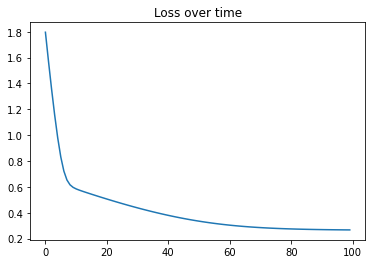

In [ ]:
w = torch.rand(2) # Our parameters
w.requires_grad = True # Explain

optimizer = torch.optim.SGD([w], lr=0.2) # What des SGD stand for?

losses = [] # Keep track of our losses (RMSE values)
ws = [] # Keep track of the values we predicted

for i in range(100):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get our outputs
  y_hat = w[0]*x + w[1] 

  # Calculate our loss
  loss = rmse(y, y_hat)

  # Store the loss for later
  losses.append(loss.detach().item())
  ws.append(w.clone().detach().numpy())

  # Print out updates ever few iterations
  if i % 20 == 0:
    print('loss at step', i, ':', loss)

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update. 
  

plt.plot(losses)
plt.title('Loss over time')

In [ ]:
w # View the learned parameters

tensor([2.9089, 0.2737], requires_grad=True)

In [ ]:
w.grad # We can see the gradients of the loss with respect to w (now small since we're close to optimum)

tensor([-0.0262,  0.0145])

<matplotlib.legend.Legend>

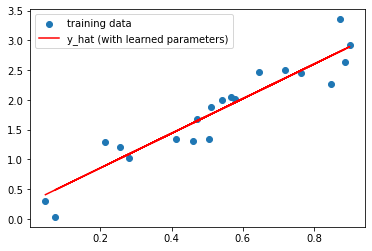

In [ ]:
# Plot predictions with these parameters
plt.scatter(x, y, label='training data')
y_hat = w[0]*x + w[1]
plt.plot(x, y_hat.detach(), c='red', label='y_hat (with learned parameters)')
plt.legend()

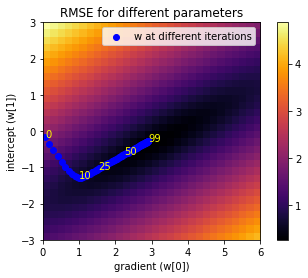

In [ ]:
#@title Show the loss landscape and our path through it:
w1, w2 = torch.meshgrid(torch.arange(0, 6, 0.2), torch.arange(-3, 3, 0.2), indexing='ij') # Grids with both parameters
width, height = w1.shape

# Calculating y_hat for each seat of params and then the resulting RMSEs
y_preds = x.unsqueeze(0).expand(width*height, -1) * w1.flatten().unsqueeze(0).expand(20, -1).T + w2.flatten().unsqueeze(0).expand(20, -1).T
rmses = torch.mean((y.unsqueeze(0).expand(width*height, -1)-y_preds)**2, dim=1)**0.5

# Showing the loss landscape
plt.imshow(rmses.reshape(width, height).T, cmap='inferno', extent=[0, 6, -3, 3])
plt.colorbar()
plt.title('RMSE for different parameters')
plt.xlabel('gradient (w[0])')
plt.ylabel('intercept (w[1])')

# Showing the path we took over time. We need x, -y due to the way imshow works 
plt.scatter([w[0] for w in ws], [-w[1] for w in ws], c='blue', label='w at different iterations')
for i in [0, 10, 25, 50, 99]:
  plt.annotate(i, (ws[i][0], -ws[i][1]), c='yellow')
plt.legend()
plt.show()

Instead of optimizer.step(), we could do `w -= w.grad * 0.2` where 0.2 is the learning rate and the minus sign is because we want to move in the direction that reduces loss (so opposite to the steepest gradient). 

EXERCISE: Try this and confirm for yourself that this works.

THINK/DISCUSS: Does this make sense? Are there any issues? What happens when the gradients are small? What happens when our step size (learning rate) is too high?

THINK/DISCUSS: What kinds of problems can we solve with this tool? Can you think of examples? What are the limitations?

### VIDEO: GD wrapup and ethics of optmization

### Ethics - What are we optimizing for?
Choosing a loss function might seem like a fairly mundane and technical questions, but the choice of what we're optimizing for can have real-world impacts. What situations have you seen or experienced when the wrong target was picked?

TODO link more resources

## Optimization Methods

Improvements in optimization (momentum, adaptive methods, maybe even a bonus section on second order stuff like shampoo and a paper read of LocoProp) 

Gradient Descent (or Stochastic Gradient Descent, which is just GD on batches of data rather than the full dataset) is just one optimization method. There are many improvements that can be made. If you're interested, here is a great rundown of the many alternatives that are used today: https://ruder.io/optimizing-gradient-descent/

One useful idea that is bundled with optimizers in PyTorch is that of regularization. It's a large topic, but in essence regularization is concerned with smoothing things out and simplifying models or parameter sets by avoiding any values that are too extreme.

TODO link to a separate notebook exploring optimizers or leave for later (maybe the NN section)


## Exercise: optimize pixels in an image to match some loss (without explaining it)? OR have a black box function that goes from z -> orb, craft a loss for orb color and optimize z to get a particular orb color. Later in the GAN section we'll make the GAN which will hide behind the scenes and enable this!

Maybe link Karpathy's intro talk w/ micrograd?

Include an NN without explaining it as in NMA?

